In [1]:
import numpy as np 
import os
import matplotlib.pyplot as plt
import cv2
import glob
from google.colab.patches import cv2_imshow

In [2]:
DATASET = 'MENDELEY'

if DATASET == 'MENDELEY':
    PATH = '/content/drive/MyDrive/AV_split/'
    TRAIN_PATH = PATH+'train/'
    TRAIN_IMAGE_PATH = TRAIN_PATH + 'images'
    TRAIN_MASK_PATH = TRAIN_PATH + 'GT_vessel'
    SIZE = 512
    
    TEST_PATH = PATH+'test/'
    TEST_IMAGE_PATH = TEST_PATH + 'images'
    TEST_MASK_PATH = TEST_PATH + 'GT_vessel'
    SAVE_TEST_IMAGE_PATH = TEST_PATH + 'predict'
    
elif DATASET == 'STARE':
    PATH = '/content/drive/MyDrive/STARE/'
    TRAIN_PATH = PATH+'train/'
    TRAIN_IMAGE_PATH = TRAIN_PATH + 'images'
    TRAIN_MASK_PATH = TRAIN_PATH + 'GT'
    SIZE = 512
    
    TEST_PATH = PATH+'test/'
    TEST_IMAGE_PATH = TEST_PATH + 'images'
    TEST_MASK_PATH = TEST_PATH + 'GT'
    SAVE_TEST_IMAGE_PATH = TEST_PATH + 'predict'

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


0.00784313725490196 0.8666666666666667
(512, 512, 1)
[0.00784314 0.01176471 0.01568627 0.01960784 0.02352941 0.02745098
 0.03137255 0.03529412 0.03921569 0.04313725 0.04705882 0.05098039
 0.05490196 0.05882353 0.0627451  0.06666667 0.07058824 0.0745098
 0.07843137 0.08235294 0.08627451 0.09019608 0.09411765 0.09803922
 0.10196078 0.10588235 0.10980392 0.11372549 0.11764706 0.12156863
 0.1254902  0.12941176 0.13333333 0.1372549  0.14117647 0.14509804
 0.14901961 0.15294118 0.15686275 0.16078431 0.16470588 0.16862745
 0.17254902 0.17647059 0.18039216 0.18431373 0.18823529 0.19215686
 0.19607843 0.2        0.20392157 0.20784314 0.21176471 0.21568627
 0.21960784 0.22352941 0.22745098 0.23137255 0.23529412 0.23921569
 0.24313725 0.24705882 0.25098039 0.25490196 0.25882353 0.2627451
 0.26666667 0.27058824 0.2745098  0.27843137 0.28235294 0.28627451
 0.29019608 0.29411765 0.29803922 0.30196078 0.30588235 0.30980392
 0.31372549 0.31764706 0.32156863 0.3254902  0.32941176 0.33333333
 0.3372549 

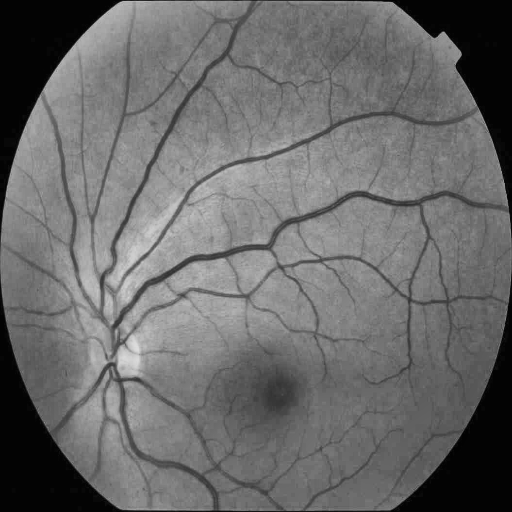

In [4]:
def clahe_equalized(image):    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))    
    image_equalized = clahe.apply(image)
    
    return image_equalized

def image_aug(image):
    image = image[:,:,1]
    image = clahe_equalized(image)

    # av_split img shaoe 1000, 1504
    if DATASET == 'MENDELEY':
      image = image[70:970, 200:1255]

    image = cv2.resize(image, (512, 512))
    image = np.reshape(image, image.shape + (1,))

    image = image / 255
    return image

def read_image(image_full_path):
    image = cv2.imread(
      image_full_path
    )
    image = image_aug(image)

    return image

# example
if DATASET == 'MENDELEY':
  image = read_image(
    '/content/drive/MyDrive/AV_split/train/images/IM000001.JPG', 
  )
elif DATASET == 'STARE':
  image = read_image(
    '/content/drive/MyDrive/STARE/train/images/im0001.ppm', 
  )

print(image.min(), image.max())
print(image.shape)
print(np.unique(image))
cv2_imshow(image*255)

0.0 1.0
(512, 512, 1)
[0. 1.]


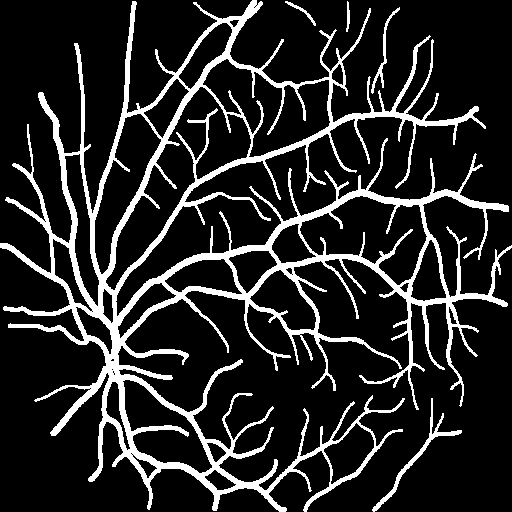

In [5]:
def mask_aug(mask):
    thresh = 128
    mask = cv2.threshold(mask, thresh, 255, cv2.THRESH_BINARY)[1]

    mask = mask[70:970, 200:1255]
    mask = cv2.resize(mask, (512, 512))
    mask = np.reshape(mask, mask.shape + (1,))

    if DATASET == 'MENDELEY':
        mask = 255 - mask
    
    mask = mask / 255

    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0

    return mask

def read_mask(mask_full_path):
    mask = cv2.imread(
        mask_full_path, 
        cv2.IMREAD_GRAYSCALE)
    mask = mask_aug(mask)

    return mask

if DATASET == 'MENDELEY':
    mask = read_mask(
        '/content/drive/MyDrive/AV_split/train/GT_vessel/IM000001--vessels.jpg')
elif DATASET == 'STARE':
    mask = read_mask(
        '/content/drive/MyDrive/STARE/train/GT/im0001.ah.ppm')

print(mask.min(), mask.max())
print(mask.shape)
print(np.unique(mask))

cv2_imshow(mask*255)

In [6]:
image_names = glob.glob(TRAIN_IMAGE_PATH + '/*.JPG')
image_names.sort()

images = [read_image(image) for image in image_names]
image_dataset = np.array(images)

mask_names = glob.glob(TRAIN_MASK_PATH + '/*.jpg')
mask_names.sort()

masks = [read_mask(mask) for mask in mask_names]
mask_dataset = np.array(masks)

In [7]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (25, 512, 512, 1)
Mask data shape is:  (25, 512, 512, 1)
Max pixel value in image is:  1.0
Labels in the mask are :  [0. 1.]


In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 42)

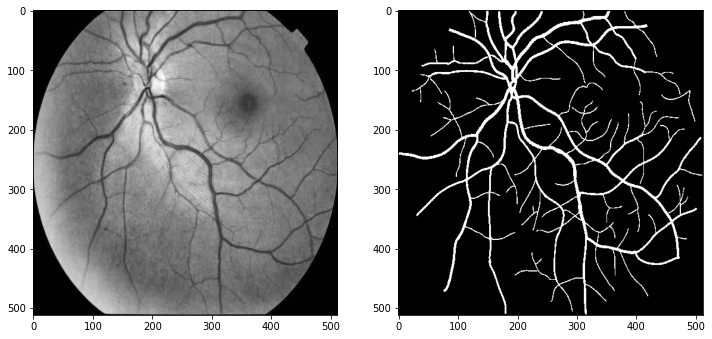

In [9]:
import random

image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,0], cmap='gray')
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,0], cmap='gray')
plt.show()

In [10]:
# Building Unet by dividing encoder and decoder into blocks

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x) 
    x = Activation("relu")(x)

    return x

# Encoder block: Conv block followed by maxpooling

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

# Decoder block
# skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

# Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) # Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  # Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  # Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model


In [12]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
input_shape

(512, 512, 1)

In [15]:
model = build_unet(input_shape, n_classes=1)
model.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

sigmoid
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 512, 512, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 512, 512, 64  256        ['conv2d_19[0][0]']              
 ormalization)                  )                                                     

In [16]:
history = model.fit(X_train, y_train, 
                    batch_size = 5, 
                    verbose = 1, 
                    epochs = 100, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Epoch 1/100
4/4 [==============================] - 26s 2s/step - loss: 0.5964 - accuracy: 0.7331 - val_loss: 0.8984 - val_accuracy: 0.3925
Epoch 2/100
4/4 [==============================] - 5s 1s/step - loss: 0.3562 - accuracy: 0.9098 - val_loss: 1.1774 - val_accuracy: 0.3781
Epoch 3/100
4/4 [==============================] - 5s 1s/step - loss: 0.2783 - accuracy: 0.9225 - val_loss: 1.1323 - val_accuracy: 0.3805
Epoch 4/100
4/4 [==============================] - 5s 1s/step - loss: 0.2455 - accuracy: 0.9256 - val_loss: 28.3557 - val_accuracy: 0.3137
Epoch 5/100
4/4 [==============================] - 5s 1s/step - loss: 0.2302 - accuracy: 0.9262 - val_loss: 1.2588 - val_accuracy: 0.4869
Epoch 6/100
4/4 [==============================] - 5s 1s/step - loss: 0.2174 - accuracy: 0.9288 - val_loss: 0.6238 - val_accuracy: 0.7168
Epoch 7/100
4/4 [==============================] - 5s 1s/step - loss: 0.2073 - accuracy: 0.9301 - val_loss: 2.8514 - val_accuracy: 0.7032
Epoch 8/100
4/4 [===============

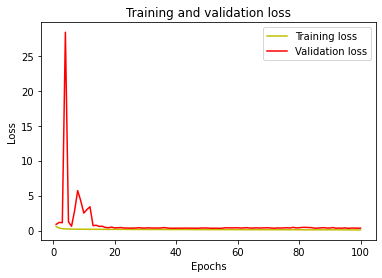

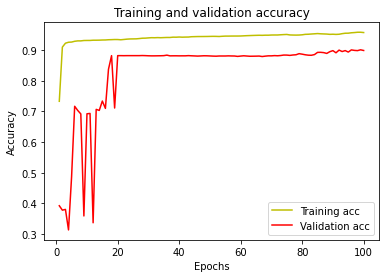

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

(1, 512, 512, 1)
1/1 [==============================] - 0s 23ms/step
(512, 512)


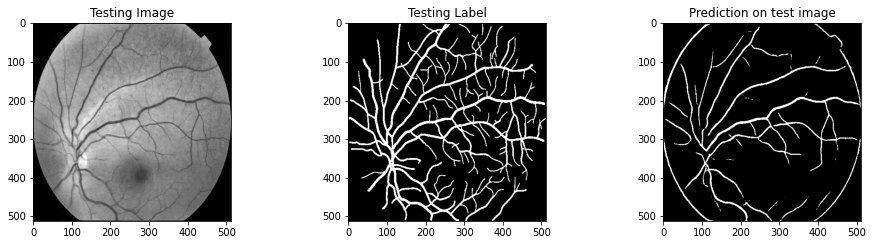

In [19]:

threshold = 0.5
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')
